Bucket size = 131072
[0, 0, 0, 0, 0, 0, 0, 0]
4
1
7
0
0
0
0
0
0
1
0
1
2
3
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]
Parsing file ...
Parsing Finished!
[[1328085, 313885, 216027, 169120, 141991, 122685, 108743, 99004], [1327696, 313540, 216214, 169434, 142404, 123365, 108808, 98999]]
[2655781, 627425, 432241, 338554, 284395, 246050, 217551, 198003]


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


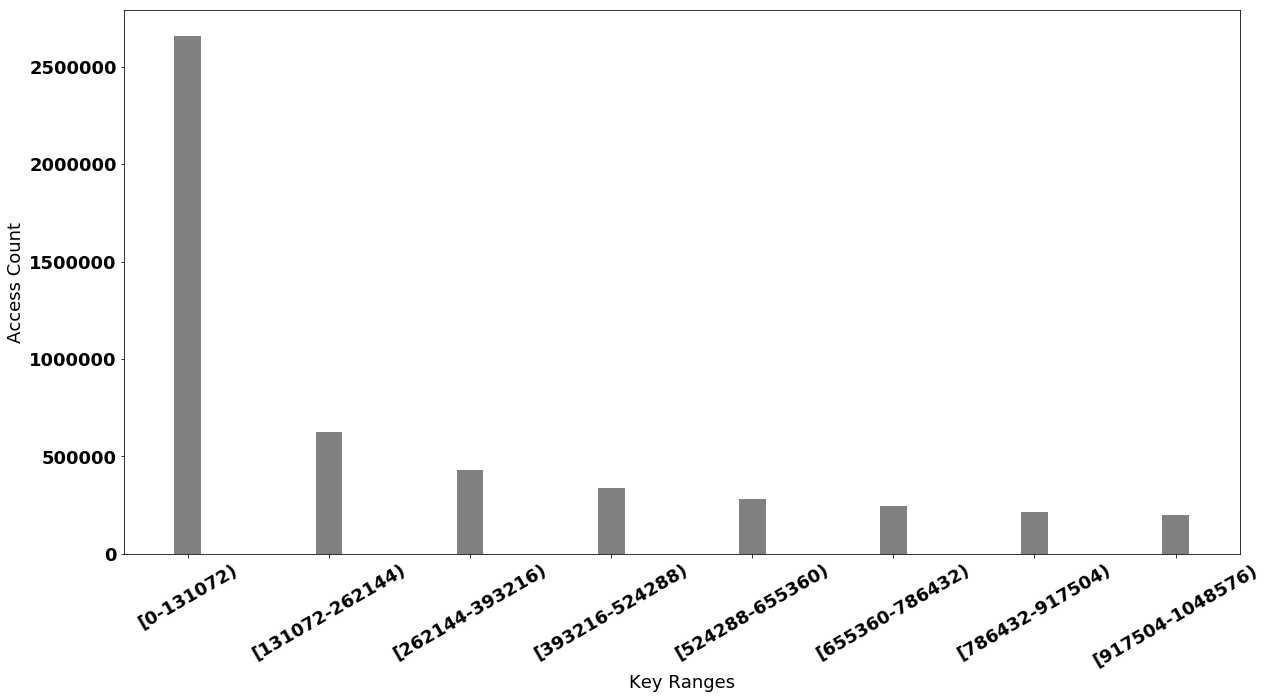

In [89]:
%matplotlib inline
import re
import os
import sys
#for plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random as r
datafiles = ['ycsb_readonly_wl_2.5Mtxn_1Mrecs.out',
             'ycsb_50pwrite_th0.6_wl_2.5Mtxn_1Mrecs.out',
             'ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out']

fname ='ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out'
# fname ='ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out'
# fname = 'ycsb_readonly_wl_2.5Mtxn_1Mrecs.out'
i = 0
g_max = -1
g_min = -1
PLANNER_CNT = 2

table_size = 1048576
no_buckets = 8
bucket_size = int(table_size/no_buckets)
print("Bucket size = {:d}".format(bucket_size))
buckets = [0]*no_buckets
print(buckets)

def hashKeyToBucket(key):
    for i in range(no_buckets):
#         print(i)
        if (key >= i*bucket_size and key < (i+1)*bucket_size):
            return i
#     if does not fall into any of the buckets (should not happen), assign to bucket 0
    return 0

def hashKeyToBucket2(key):
    return key % no_buckets;

print(hashKeyToBucket(bucket_size*4))
print(hashKeyToBucket(173648))
print(hashKeyToBucket(1013625))
print(hashKeyToBucket(1048576))
print(hashKeyToBucket(1))
print(hashKeyToBucket(2))
print(hashKeyToBucket(3))

print(hashKeyToBucket2(bucket_size*4))
print(hashKeyToBucket2(173648))
print(hashKeyToBucket2(1013625))
print(hashKeyToBucket2(1048576))
print(hashKeyToBucket2(1))
print(hashKeyToBucket2(2))
print(hashKeyToBucket2(3))


#initialize planners
planners = []
for i in range(PLANNER_CNT):
    planners.append([0]*no_buckets)
print(planners)

plt_buckets_keys = []
for i in range(no_buckets):
    plt_buckets_keys.append("[{:d}-{:d})".format(i*bucket_size,bucket_size*(i+1)))
    
# plt_buckets_keys.append("[{:d}-{:d})".format(0,bucket_size))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size,bucket_size*2))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size*2,bucket_size*3))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size*3,bucket_size*4))

plot_data = [];
buckets_2 = [16409900, 3856648, 2650184, 2083308]
batch_size = 500*1000

def plot_figure(plt_buckets_keys, _buckets, _planners, splot):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(splot)
    pcolors = ['r','b','g','gray']
    for i, pln in enumerate(_planners, start=0):
#         print(pln)
        pln_d = {plt_buckets_keys[0]:pln[0],
             plt_buckets_keys[1]:pln[1], 
             plt_buckets_keys[2]:pln[2],
             plt_buckets_keys[3]:pln[3]}
#         print(pln_d)    
        x = np.arange(len(pln_d))
        ax.bar(x+(w*(i+1)), pln_d.values(),width=w, color=pcolors[i],align='center')
    
    ax.set_xticks(x)
    ax.set_xticklabels(plt_buckets_keys, rotation=0)
    
    ax.set_ylabel('Access Count')
    ax.set_xlabel('Key Ranges')
    ax.autoscale(tight=True)

def parseFileForStats(_fname, planners):
    txn_cnt = 0
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('YCSB_TXN\{(.*)\}', cline)
            if m: #line is a transaction
                txn_cnt = txn_cnt + 1
    print("Txn_cnt = {:d}".format(txn_cnt))
                
def parseFile(_fname, planners):
    bi = 0
    plot_more = True
    plot_count = 0
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('YCSB_TXN\{(.*)\}', cline)
    #         if i < 10:
            if m: #line is a transaction
                txn_str = m.group(1)                
    #                 print(txn_str)
                pli = r.randrange(len(planners))
                keys = list(map(lambda x: int(x.split(',')[1]), txn_str.split(':')))
                for k in keys:
                    index = hashKeyToBucket(k)
#                     index = hashKeyToBucket2(k)
                    planners[pli][index] = planners[pli][index] + 1
                    buckets[index] = buckets[index] + 1        
                # increment batch
                bi = bi + 1
                if (bi == batch_size and plot_more):
                    bi = 0
                    splot = 111
#                     plot_figure(plt_buckets_keys,buckets_2, planners, splot)
                    planners = []
                    for i in range(PLANNER_CNT):
                        planners.append([0]*no_buckets)
                    plot_count = plot_count + 1
                if (plot_count == 1):
                    plot_more = False
                if not plot_more:
                    break

                
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)    
w = 0.19    



print("Parsing file ...")
parseFile(datafiles[2], planners)
# parseFileForStats(datafiles[2], planners)
print("Parsing Finished!")
print(planners)
print(buckets)

# Precomputed data

def plot_figure_oneset(plt_buckets_keys, _buckets):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)    
    x = np.arange(no_buckets)
    ax.bar(x, _buckets,width=w, color='gray',align='center')

    ax.set_xticks(x)
    ax.set_xticklabels(plt_buckets_keys, rotation=30)
    
    ax.set_ylabel('Access Count')
    ax.set_xlabel('Key Ranges')
#     ax.autoscale(tight=True)

buckets_0 = [6255320, 6257435, 6258752, 6228533]
buckets_1 = [14344454, 4601588, 3336508, 2717490]
buckets_2 = [16409900, 3856648, 2650184, 2083308]

planners_0 = [[3129536, 3131653, 3128575, 3118406], [3125784, 3125782, 3130177, 3110127]]
planners_1 = [[7169667, 2300193, 1667773, 1358967], [7174787, 2301395, 1668735, 1358523]]
planners_11 = [[7167936, 2299492, 1668671, 1357141], [7176518, 2302096, 1667837, 1360349]]
planners_2 = [[8209417, 1928131, 1326439, 1040283], [8200483, 1928517, 1323745, 1043025]]
planners_21 = [[8202535, 1928081, 1324651, 1040663], [8207365, 1928567, 1325533, 1042645]]

# planners = [[4103191, 964295, 661774, 519860], [4102256, 965006, 663124, 520354], [4098977, 962325, 662525, 520943],
#             [4105476, 965022, 662761, 522151]]
# plot_figure(plt_buckets_keys,buckets_0, planners_0)
# plot_figure(plt_buckets_keys,buckets_1, planners_1)
# plot_figure(plt_buckets_keys,buckets_1, planners_2)
plot_figure_oneset(plt_buckets_keys,buckets)

In [77]:
os.getcwd()

'/Users/qadahtm/Dev/halstead/deneva_project/pynb'

In [4]:
def extract_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
#                     print(i,a)
                    if i == 1:
                        asline = a.split('=')
                        res[asline[0]] = asline[1]
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    return res;


directory = "/Users/qadahtm/Dev/halstead/results/quecc"

resFiles = os.listdir(directory)
cc_alg_map = {'nowait':1, 'quecc':13}
x_points = [2,4,8,16]
data = {'cc_alg':[],
        'tput':[],
        'worker_cnt':[],
        'trial_num':[]
       }
dfcols = ['cc_alg', 'w_cnt', 'tput', 'trial_no']
for fname in resFiles:
    m = re.search("([a-z]+)_(\d+)p_(\d+)w_100mpr_16Mrec_(c|s)_t(\d).txt",fname)
    wthd_cnt = 0
    extracted_data = {}
    cc_alg = ''
    trial_num = 0;
    if m:
        if (m.group(4) == 's'):
            cc_alg = m.group(1)
            trial_num = m.group(5)
            if (cc_alg == 'nowait'):
                wthd_cnt = int(m.group(3))                     
            elif (cc_alg == 'quecc'):
                wthd_cnt = int(m.group(3)) + int(m.group(2))
            
            if (wthd_cnt in set(x_points)):
#                 print(cc_alg+' '+str(wthd_cnt))
                e_data = extract_from_file(directory+'/'+fname)
                data['tput'].append(float(e_data['tput']))
                data['worker_cnt'].append(wthd_cnt)
                data['trial_num'].append(int(trial_num))
                data['cc_alg'].append(cc_alg)

                    
                
print(data)
df = pd.DataFrame(data)    

{'cc_alg': ['nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'nowait', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc', 'quecc'], 'tput': [225383.949388, 224136.882609, 223466.382726, 63226.583345, 66839.0499, 65955.899891, 128923.966671, 132521.483112, 132145.54983, 267627.099072, 258888.148882, 255807.249164, 106588.016407, 106132.249814, 92829.199853, 118613.066487, 101973.533187, 119999.999546, 131277.482955, 131461.315755, 127710.549596, 114088.549736, 106052.71457, 114085.066402], 'worker_cnt': [16, 16, 16, 2, 2, 2, 4, 4, 4, 8, 8, 8, 2, 2, 2, 4, 4, 4, 8, 8, 8, 16, 16, 16], 'trial_num': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]}


In [5]:
grouped = df.groupby(['cc_alg','worker_cnt']).tput.agg(['count', 'min', 'max', 'mean'])

In [6]:
grouped

count            min            max           mean
cc_alg worker_cnt                                                    
nowait 2               3   63226.583345   66839.049900   65340.511045
       4               3  128923.966671  132521.483112  131196.999871
       8               3  255807.249164  267627.099072  260774.165706
       16              3  223466.382726  225383.949388  224329.071574
quecc  2               3   92829.199853  106588.016407  101849.822025
       4               3  101973.533187  119999.999546  113528.866407
       8               3  127710.549596  131461.315755  130149.782769
       16              3  106052.714570  114088.549736  111408.776903

In [7]:
grouped.index

MultiIndex(levels=[['nowait', 'quecc'], [2, 4, 8, 16]],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]],
           names=['cc_alg', 'worker_cnt'])

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


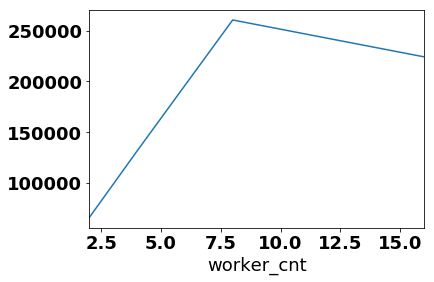

In [8]:
grouped.loc['nowait']['mean'].plot()

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


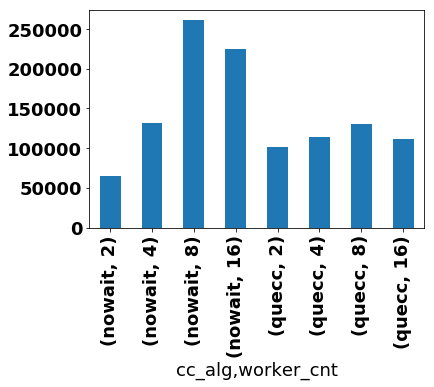

In [9]:
grouped['mean'].plot('bar')

In [10]:
grouped.loc['NOWAIT'][1:]
# grouped.loc['QUECC'][:3]

KeyError: 'the label [NOWAIT] is not in the [index]'

In [65]:
data_csv = '/Users/qadahtm/Dev/halstead/results/aws_sum_data_pt6.csv'
print(os.getcwd())
df = pd.DataFrame.from_csv(data_csv)
grouped = df.groupby(['cc_alg','wthd_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
grouped

/Users/qadahtm/Dev/halstead/deneva_project/pynb


count            min            max           mean
cc_alg    wthd_cnt                                                    
MAAT      2             1   63184.349913   63184.349913   63184.349913
          4             1  123855.666291  123855.666291  123855.666291
          8             1  243777.232635  243777.232635  243777.232635
          16            1  377311.381730  377311.381730  377311.381730
MVCC      2             1   58250.283137   58250.283137   58250.283137
          4             1  129798.216346  129798.216346  129798.216346
          8             1  260822.665445  260822.665445  260822.665445
          16            1  452140.464466  452140.464466  452140.464466
NOWAIT    2             1   83476.983176   83476.983176   83476.983176
          4             1  170251.066099  170251.066099  170251.066099
          8             1  332714.549312  332714.549312  332714.549312
          16            1  603112.180499  603112.180499  603112.180499
QUECC     1             1  164638.414353  164638.414353  164638.414353
          2             1  210285.199849  210285.199849  210285.199849
          4             1  284556.250346  284556.250346  284556.250346
          8             1  328375.932414  328375.932414  328375.932414
TIMESTAMP 2             1   87417.083228   87417.083228   87417.083228
          4             1  173877.966901  173877.966901  173877.966901
          8             1  343452.432732  343452.432732  343452.432732
          16            1  605159.430661  605159.430661  605159.430661
WAITDIE   2             1   76960.483042   76960.483042   76960.483042
          4             1  157928.683039  157928.683039  157928.683039
          8             1  313858.682313  313858.682313  313858.682313
          16            1  562928.148480  562928.148480  562928.148480

/Users/qadahtm/Dev/halstead/deneva_project/pynb
0
MAAT
1
MVCC
2
NOWAIT
3
QUECC
4
TIMESTAMP
5
WAITDIE


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


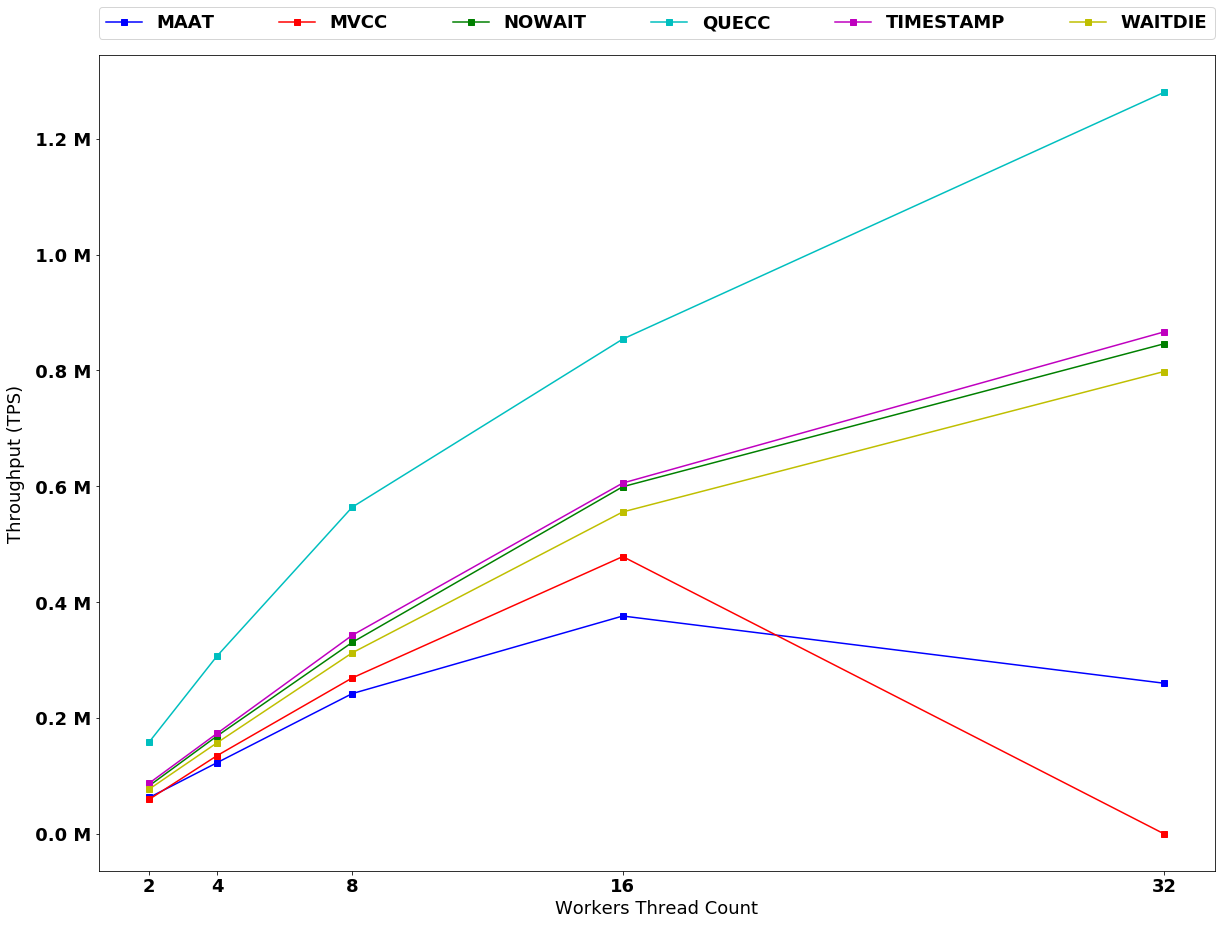

In [68]:
import matplotlib.ticker as ticker  

data_csv = '/Users/qadahtm/Dev/halstead/results/aws_sum_data_uni.csv'
print(os.getcwd())
df = pd.DataFrame.from_csv(data_csv)
grouped = df.groupby(['cc_alg','wthd_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
grouped
# grouped.loc['NOWAIT']  
ss = list(grouped.index[:].levels[0])
y = [0.0]*(len(ss))
ys = [0.0]*(len(ss))
x = list(grouped.loc['NOWAIT'].index)
us = 1000000
for i,s in enumerate(ss):
    print(i)
    print(s)
    y[i] = list(grouped.loc[s]['mean'])
    ys[i] = list( map(lambda x : x/us, y[i]))
# y[0] = list(grouped.loc['NOWAIT']['mean'])
# y[1] = list(grouped.loc['QUECC']['mean'])
# y[2] = list(grouped.loc['DUMMYCC'][1:]['mean'])

# ys[0] = list( map(lambda x : x/us, y[0]))
# ys[1] = list( map(lambda x : x/us, y[1]))
# ys[2] = list( map(lambda x : x/us, y[2]))

ls = ['bs-', 'rs-', 'gs-', 'cs-', 'ms-', 'ys-', 'bs*', 'y^--' ]
plt.figure(figsize=(20,15))
# plt.figure()
ax = plt.subplot(111)
pcolors = ['r','b','g','gray']
ax.set_xscale('linear')
for i,s in enumerate(ss):
    ax.plot(x, ys[i], ls[i], label=s)

# ax.plot(x, y1s, 'bs-', label='NO_WAIT')
# ax.plot(x, y2s, 'r^-', label='QueCC')
# ax.plot(x, y3s, 'k^-', label='DummyCC')
ax.xaxis.set_ticks(x)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f M'))

ax.set_ylabel('Throughput (TPS)')
ax.set_xlabel('Workers Thread Count')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=6, mode="expand", borderaxespad=0.)

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


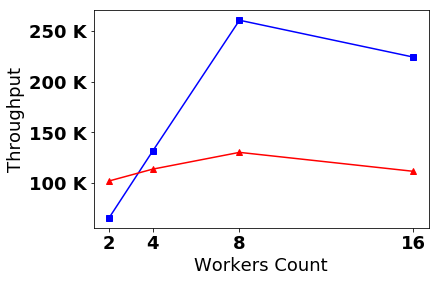

In [204]:
import matplotlib.ticker as ticker    
x = list(grouped.loc['nowait'].index)
y1 = list(grouped.loc['nowait']['mean'])
y2 = list(grouped.loc['quecc']['mean'])

y1s = list( map(lambda x : x/1000, y1))
y2s = list( map(lambda x : x/1000, y2))

# plt.figure(figsize=(20,10))
plt.figure()
ax = plt.subplot(111)
pcolors = ['r','b','g','gray']
ax.set_xscale('linear')
ax.plot(x, y1s, 'bs-')
ax.plot(x, y2s, 'r^-')
ax.xaxis.set_ticks(x)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d K'))
# ax.set_xticks(x)
# ax.set_xticklabels(plt_buckets_keys, rotation=0)

ax.set_ylabel('Throughput')
ax.set_xlabel('Workers Count')
# plt.autoscale(tight=True)

In [5]:
directory = "/Users/qadahtm/Dev/halstead/results/quecc2"

def view_planner_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
                    mq = re.search('quecc\_plan(\d+)\_(\w+)=(\d+\.?\d*)', a)
                    if mq:
                        row = [mq.group(1), mq.group(2), mq.group(3)]
                        key = mq.group(2)
                        if key in res.keys():
                            res[mq.group(2)].append(float(mq.group(3)))
                        else:
                            res[mq.group(2)] =[float(mq.group(3))]
#                         print(row)
                        print(a)
                print(sline[0])
                print(sline[1])
                print(sline[2])
#     print(res)
    return res;
# fname = 'quecc_8p_8w_100mpr_16Mrec_s_t1.txt'
# fname = 'quecc_12p_4w_100mpr_16Mrec_s_t1.txt'
# fname = 'quecc_12p_4w_500Ktif_16Mrec_s_t1.txt'
fname = 'quecc_8p_8w_1Mtif_16Mrec_s_t1.txt'
time_data = view_planner_from_file(directory+"/"+fname)
df = pd.DataFrame(time_data)
# df['idle_time']
df

quecc_plan0_txn_cnt=910139
quecc_plan0_batch_cnt=8
quecc_plan0_mem_alloc_time=1.785524
quecc_plan0_idle_time=18.525415
quecc_plan0_batch_proc_time=59.516995
quecc_plan0_queue_deq_cnt=910139
quecc_plan0_queue_dequeue_time=19.676115
quecc_plan0_queue_deq_pop_time=13.732783
quecc_plan0_queue_deq_free_mem_time=0.147931
quecc_plan0_batch_delivery_time=0.000551
quecc_plan0_txn_proc_time=20.795285
quecc_plan0_total_time=60.000000
quecc_plan1_txn_cnt=912987
quecc_plan1_batch_cnt=8
quecc_plan1_mem_alloc_time=1.875406
quecc_plan1_idle_time=17.329376
quecc_plan1_batch_proc_time=59.368332
quecc_plan1_queue_deq_cnt=912987
quecc_plan1_queue_dequeue_time=18.269683
quecc_plan1_queue_deq_pop_time=12.590462
quecc_plan1_queue_deq_free_mem_time=0.147464
quecc_plan1_batch_delivery_time=0.000109
quecc_plan1_txn_proc_time=23.107919
quecc_plan1_total_time=60.000003
quecc_plan2_txn_cnt=912737
quecc_plan2_batch_cnt=8
quecc_plan2_mem_alloc_time=1.628198
quecc_plan2_idle_time=17.214410
quecc_plan2_batch_proc_time

,batch_cnt,batch_delivery_time,batch_proc_time,idle_time,mem_alloc_time,queue_deq_cnt,queue_deq_free_mem_time,queue_deq_pop_time,queue_dequeue_time,total_time,txn_cnt,txn_proc_time
0,8.0,0.000551,59.516995,18.525415,1.785524,910139.0,0.147931,13.732783,19.676115,60.000000,910139.0,20.795285
1,8.0,0.000109,59.368332,17.329376,1.875406,912987.0,0.147464,12.590462,18.269683,60.000003,912987.0,23.107919
2,8.0,0.000169,59.359617,17.214410,1.628198,912737.0,0.145638,11.269914,16.411494,59.999972,912737.0,24.860728
3,8.0,0.000166,59.365516,15.755487,1.776600,913297.0,0.145717,11.820569,16.011290,60.000004,913298.0,26.590141
4,8.0,0.000368,59.420410,19.477936,1.561331,912604.0,0.149392,19.965904,25.927191,60.000000,912604.0,13.907857
5,8.0,0.000144,59.339037,10.900176,1.605304,913258.0,0.149303,25.491753,36.476497,59.999992,913257.0,12.144780
6,8.0,0.000123,59.357868,11.045039,1.632633,913190.0,0.152284,25.821288,36.940645,60.000001,913190.0,11.535035
7,8.0,0.000110,59.419401,11.043254,1.630263,911708.0,0.151129,25.793326,36.910556,60.000000,911708.0,11.571903


In [17]:
def plot_planner_times(df):
    # Create the general blog and the "subplots" i.e. the bars
    f, ax1 = plt.subplots(1, figsize=(16,5))

    # Set the bar width
    bar_width = 0.40

    colors = ['#d7191c','#fdae61','#abdda4','#2b83ba']


    # positions of the left bar-boundaries
    bar_l = [i-(bar_width) for i in range(len(df['idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['idle_time'],
            # set the width
            width=bar_width,
            # with the label pre score
            label='Idle time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[0])

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            # using the mid_score data
            df['queue_dequeue_time'],
            # set the width
            width=bar_width,
            # with pre_score on the bottom
            bottom=df['idle_time'],
            # with the label mid score
            label='Deq. time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[1])

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            # using the post_score data
            df['txn_proc_time'],
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[i+j for i,j in zip(df['idle_time'],df['queue_dequeue_time'])],
            # with the label post score
            label='Txn proc. time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[2])
    ax1.bar(bar_l,
            # using the post_score data
            [60-(i+j+k) for i,j,k in zip(df['idle_time'],df['queue_dequeue_time'], df['txn_proc_time'])],
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[(i+j+k) for i,j,k in zip(df['idle_time'],df['queue_dequeue_time'], df['txn_proc_time'])],
            # with the label post score
            label='Other times',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[3])

    # set the x ticks with names
    plt.xticks(bar_l,['Planner_'+str(i) for i in range(len(df['idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Planner threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)


    # Set a buffer around the edge
#     plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

In [7]:
def view_exec_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
#                     print(i,a)
#                     if i == 1:
#                         asline = a.split('=')
#                         res[asline[0]] = asline[1]
                    mq = re.search('quecc\_exec(\d)\_(\w+)=(\d+\.?\d*)', a)
                    if mq:
#                         res['index'].append(int(i))
                        row = [mq.group(1), mq.group(2), mq.group(3)]
                        key = mq.group(2)
                        if key in res.keys():
                            res[mq.group(2)].append(float(mq.group(3)))
                        else:
                            res[mq.group(2)] =[float(mq.group(3))]
#                         print(row)
                        print(a)
                print(sline[0])
                print(sline[1])
                print(sline[2])
#     print(res)
    return res;
time_data = view_exec_from_file(directory+"/"+fname)
df = pd.DataFrame(time_data)
df

quecc_exec0_txn_cnt=193132
quecc_exec0_txn_frag_cnt=9012524
quecc_exec0_batch_part_cnt=64
quecc_exec0_batch_cnt=8
quecc_exec0_batch_proc_time=9.393338
quecc_exec0_mem_free_time=0.248240
quecc_exec0_idle_time=49.950395
quecc_exec1_txn_cnt=671368
quecc_exec1_txn_frag_cnt=9016019
quecc_exec1_batch_part_cnt=64
quecc_exec1_batch_cnt=8
quecc_exec1_batch_proc_time=10.889267
quecc_exec1_mem_free_time=1.289623
quecc_exec1_idle_time=48.598317
quecc_exec2_txn_cnt=1081
quecc_exec2_txn_frag_cnt=9011985
quecc_exec2_batch_part_cnt=64
quecc_exec2_batch_cnt=8
quecc_exec2_batch_proc_time=8.003539
quecc_exec2_mem_free_time=0.207539
quecc_exec2_idle_time=51.519978
quecc_exec3_txn_cnt=470086
quecc_exec3_txn_frag_cnt=9010216
quecc_exec3_batch_part_cnt=64
quecc_exec3_batch_cnt=8
quecc_exec3_batch_proc_time=10.453187
quecc_exec3_mem_free_time=0.582248
quecc_exec3_idle_time=49.006000
quecc_exec4_txn_cnt=1026055
quecc_exec4_txn_frag_cnt=9011396
quecc_exec4_batch_part_cnt=64
quecc_exec4_batch_cnt=8
quecc_exec4_b

,batch_cnt,batch_part_cnt,batch_proc_time,idle_time,mem_free_time,txn_cnt,txn_frag_cnt
0,8.0,64.0,9.393338,49.950395,0.248240,193132.0,9012524.0
1,8.0,64.0,10.889267,48.598317,1.289623,671368.0,9016019.0
2,8.0,64.0,8.003539,51.519978,0.207539,1081.0,9011985.0
3,8.0,64.0,10.453187,49.006000,0.582248,470086.0,9010216.0
4,8.0,64.0,11.429662,50.005848,2.105265,1026055.0,9011396.0
5,8.0,64.0,21.406955,35.788205,6.621923,3444476.0,9007329.0
6,8.0,64.0,8.774116,50.702649,0.672538,377018.0,8965666.0
7,8.0,64.0,11.358943,48.622708,2.008998,1016784.0,8964865.0


In [22]:
def plot_exec_times(df):
    f, ax1 = plt.subplots(1, figsize=(15,5))

    # Set the bar width
    bar_width = 0.75

    colors = ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd']


    # positions of the left bar-boundaries
    bar_l = [i-(0.75) for i in range(len(df['idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['idle_time'],
            width=bar_width,
            label='Idle time',
            color=colors[0])

    # show whole batch partition processing
#     ax1.bar(bar_l,
#             df['batch_part_proc_time'],
#             width=bar_width,
#             bottom=df['idle_time'],
#             label='Batch part. proc. time',
#             color=colors[1])

# txn_index_lookup_time
    ax1.bar(bar_l,
            df['txn_index_lookup_time'],
            width=bar_width,
            bottom=df['idle_time'],
            label='Index lookup time',
            color=colors[1], hatch='//')

    # txn_proc_time
    ax1.bar(bar_l,
            df['txn_proc_time'],
            width=bar_width,
            bottom=[(i+j) for i,j in zip(df['idle_time'],df['txn_index_lookup_time'])],
            label='Txn. proc. time',
            color=colors[2], hatch='\\')
    
    # txn_ctx_update_time
    ax1.bar(bar_l,
            df['txn_ctx_update_time'],
            width=bar_width,
            bottom=[(i+j+k) for i,j,k in zip(df['idle_time'],df['txn_index_lookup_time'],df['txn_proc_time'])],
            label='Update txn. ctx. time',
            color=colors[3], hatch='|')
    
    # txn_commit_time
    ax1.bar(bar_l,
            df['txn_commit_time'],
            width=bar_width,
            bottom=[(i+j+k+m) for i,j,k,m in zip(df['idle_time'],df['txn_index_lookup_time'],
                                                 df['txn_proc_time'], df['txn_ctx_update_time'])],
            label='Commit time',
            color=colors[4], hatch='=')

    
    ax1.bar(bar_l,
            [60-(i+j+k+m+n) if (i+j+k+m+n) <= 60 else 0 for i,j,k,m,n in zip(df['idle_time'],
                                                 df['txn_index_lookup_time'],
                                                 df['txn_proc_time'],
                                                 df['txn_ctx_update_time'], df['txn_commit_time'])],
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[(i+j+k+m+n) for i,j,k,m,n in zip(df['idle_time'],
                                                 df['txn_index_lookup_time'],
                                                 df['txn_proc_time'],
                                                 df['txn_ctx_update_time'], df['txn_commit_time'])],
            label='Other times',
            color=colors[5], hatch='++')

    # set the x ticks with names
    plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Execution threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)


    # Set a buffer around the edge
#     plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

In [48]:
['']*10

['', '', '', '', '', '', '', '', '', '']

quecc_plan0_txn_cnt=0
quecc_plan0_batch_cnt=7255
quecc_plan0_size_batch_cnt=0
quecc_plan0_time_batch_cnt=7255
quecc_plan0_mem_alloc_time=12.494972
quecc_plan0_idle_time=20.358658
quecc_plan0_batch_proc_time=60.003231
quecc_plan0_queue_deq_cnt=5326196
quecc_plan0_reuse_exec_queue_cnt=58039
quecc_plan0_alloc_exec_queue_cnt=1
quecc_plan0_queue_dequeue_time=3.251594
quecc_plan0_queue_deq_pop_time=3.065490
quecc_plan0_queue_deq_free_mem_time=0.000000
quecc_plan0_batch_delivery_time=0.057093
quecc_plan0_txn_proc_time=32.505485
quecc_plan0_total_time=60.000491
quecc_plan1_txn_cnt=0
quecc_plan1_batch_cnt=7255
quecc_plan1_size_batch_cnt=0
quecc_plan1_time_batch_cnt=7255
quecc_plan1_mem_alloc_time=12.534478
quecc_plan1_idle_time=19.919008
quecc_plan1_batch_proc_time=60.002027
quecc_plan1_queue_deq_cnt=6621503
quecc_plan1_reuse_exec_queue_cnt=58039
quecc_plan1_alloc_exec_queue_cnt=1
quecc_plan1_queue_dequeue_time=3.703620
quecc_plan1_queue_deq_pop_time=3.471580
quecc_plan1_queue_deq_free_mem_time

,alloc_exec_queue_cnt,batch_cnt,batch_delivery_time,batch_proc_time,idle_time,mem_alloc_time,queue_deq_cnt,queue_deq_free_mem_time,queue_deq_pop_time,queue_dequeue_time,reuse_exec_queue_cnt,size_batch_cnt,time_batch_cnt,total_time,txn_cnt,txn_proc_time
0,1.0,7255.0,0.057093,60.003231,20.358658,12.494972,5326196.0,0.0,3.065490,3.251594,58039.0,0.0,7255.0,60.000491,0.0,32.505485
1,1.0,7255.0,0.054411,60.002027,19.919008,12.534478,6621503.0,0.0,3.471580,3.703620,58039.0,0.0,7255.0,60.000501,0.0,31.912860
2,1.0,7255.0,0.050219,60.000845,19.948875,12.610558,6673092.0,0.0,3.443009,3.677560,58039.0,0.0,7255.0,60.000063,0.0,31.934618
3,0.0,7254.0,0.050318,59.995229,20.013064,12.572396,6687444.0,0.0,3.379755,3.614157,58032.0,0.0,7254.0,59.999994,0.0,31.996710
4,0.0,7254.0,0.049610,59.995174,20.034972,12.614505,6690780.0,0.0,3.355453,3.589787,58032.0,0.0,7254.0,59.999996,0.0,32.026679
5,0.0,7255.0,0.048927,60.003655,20.020455,12.575363,6700338.0,0.0,3.373423,3.606650,58040.0,0.0,7254.0,59.999427,0.0,32.007572
6,0.0,7255.0,0.050300,60.003604,19.977285,12.554109,6684342.0,0.0,3.409927,3.644123,58040.0,0.0,7254.0,59.998354,0.0,31.974809
7,0.0,7255.0,0.051034,60.003304,19.949803,12.619161,6618166.0,0.0,3.444377,3.676014,58040.0,0.0,7254.0,59.997220,0.0,31.941815


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


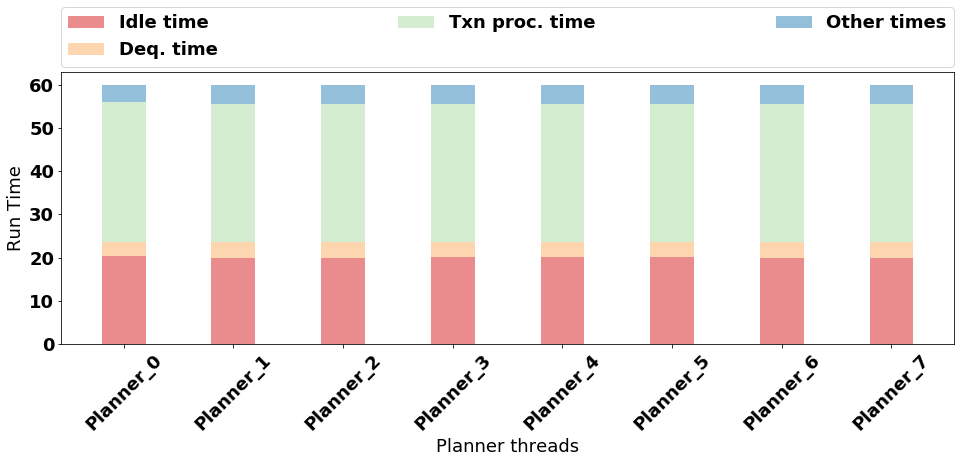

In [74]:
directory = '/Users/qadahtm/Dev/halstead/results/quecc_aws'
df = pd.DataFrame(view_planner_from_file(directory+"/QUECC_s_t0_7.txt"))
plot_planner_times(df)
df

quecc_exec0_txn_cnt=5
quecc_exec0_txn_frag_cnt=65051936
quecc_exec0_batch_part_cnt=58036
quecc_exec0_batch_cnt=7255
quecc_exec0_batch_proc_time=57.957706
quecc_exec0_mem_free_time=0.041172
quecc_exec0_idle_time=17.316232
quecc_exec0_txn_ctx_update_time=3.877085
quecc_exec0_resp_msg_create_time=0.000000
quecc_exec0_batch_part_proc_time=42.673317
quecc_exec0_txn_commit_time=0.000009
quecc_exec0_txn_index_lookup_time=10.064038
quecc_exec0_txn_proc_time=1.125601
quecc_exec1_txn_cnt=1
quecc_exec1_txn_frag_cnt=65059643
quecc_exec1_batch_part_cnt=58036
quecc_exec1_batch_cnt=7255
quecc_exec1_batch_proc_time=57.937595
quecc_exec1_mem_free_time=0.043034
quecc_exec1_idle_time=17.398953
quecc_exec1_txn_ctx_update_time=3.874669
quecc_exec1_resp_msg_create_time=0.000000
quecc_exec1_batch_part_proc_time=42.592053
quecc_exec1_txn_commit_time=0.000001
quecc_exec1_txn_index_lookup_time=10.114828
quecc_exec1_txn_proc_time=1.166792
quecc_exec2_txn_cnt=38422426
quecc_exec2_txn_frag_cnt=65209537
quecc_exec2

,batch_cnt,batch_part_cnt,batch_part_proc_time,batch_proc_time,idle_time,mem_free_time,resp_msg_create_time,txn_cnt,txn_commit_time,txn_ctx_update_time,txn_frag_cnt,txn_index_lookup_time,txn_proc_time
0,7255.0,58036.0,42.673317,57.957706,17.316232,0.041172,0.000000,5.0,0.000009,3.877085,65051936.0,10.064038,1.125601
1,7255.0,58036.0,42.592053,57.937595,17.398953,0.043034,0.000000,1.0,0.000001,3.874669,65059643.0,10.114828,1.166792
2,7255.0,58036.0,59.984721,60.002176,0.000000,12.833294,0.478113,38422426.0,15.249921,4.002518,65209537.0,11.031210,1.129339
3,7255.0,58036.0,46.451819,58.165483,13.541290,1.910411,0.046411,2233324.0,2.006546,3.959037,65046568.0,11.443159,1.115864
4,7255.0,58036.0,47.258061,58.409810,12.733396,2.207416,0.054030,2608749.0,2.328642,3.999664,65089724.0,11.499835,1.242953
5,7255.0,58036.0,47.332708,58.388153,12.660851,2.367761,0.059304,2859468.0,2.498347,3.982858,65084460.0,11.623948,1.113640
6,7255.0,58036.0,47.484833,58.409995,12.507147,2.390178,0.059785,2882452.0,2.526252,3.996397,64791090.0,11.561620,1.200934
7,7255.0,58036.0,47.663265,58.446854,12.328621,2.520026,0.063635,3065245.0,2.670953,3.990036,64806377.0,11.505786,1.204979


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


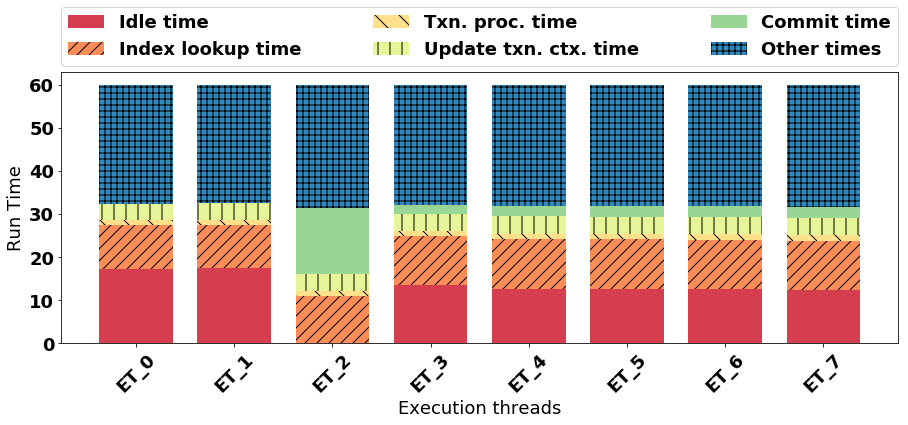

In [75]:
directory = '/Users/qadahtm/Dev/halstead/results/quecc_aws'
df = pd.DataFrame(view_exec_from_file(directory+"/QUECC_s_t0_7.txt"))
plot_exec_times(df)
df

In [264]:
(df['txn_frag_cnt']/10)/df['batch_cnt']

0    325.931231
1    325.937488
2    325.930243
3    324.373538
dtype: float64

In [269]:
tput_sample = {'dummy_cc':274743.599657, 'quecc':263500.982947, 'no_wait':261938.732251} -- 8 threads
tput_sample

{'dummy_cc': 274743.599657}

In [207]:
sample_res = {'w_thds':[2,4,8,16],
              'dummy_cc':[],
              'no_wait':[],
              'quecc':[]}

148.2495267939766

In [272]:
'NO_WAIT'.replace('_','')

'NOWAIT'

In [275]:
# Import smtplib for the actual sending function
import smtplib

# Import the email modules we'll need
# from email.message import EmailMessage

# def send_email(msg):
#     s = smtplib.SMTP('localhost')
#     s.sendmail('tqadah@purdue.edu', ['tqadah@purdue.edu'], msg)
#     s.quit()

# send_email('test content')
# msg = EmailMessage()
# msg.set_content("test content")

# me == the sender's email address
# you == the recipient's email address
# msg['Subject'] = 'subjet test'
# msg['From'] = 'tqadah@purdue.edu'
# msg['To'] = ['tqadah@purdue.edu', 'qadah.thamir@gmail.com']

# # Send the message via our own SMTP server.
# s = smtplib.SMTP('localhost')
# s.send_message(msg)
# s.quit()

ConnectionRefusedError: [Errno 61] Connection refused

In [82]:
cc_algs = ['NO_WAIT', 'QUECC', 'WAIT_DIE', 'TIMESTAMP', 'MVCC', 'CALVIN' , 'MAAT' ]
# cc_algs = ['DUMMY_CC']
wthreads = [1,2,4,8,16]
for ncc_alg in cc_algs:
    for wthd in wthreads:
        runexp = True
        if wthd == 1  and ncc_alg != 'QUECC':
            #Don't run other CCs with 1 thread 
            runexp = False

        if wthd == 16 and ncc_alg == 'QUECC':
            #Don't run QueCC with 16 threads 
            runexp = False
        if runexp:       
            print('Run exp: {}, for thd = {}, cc={}'.format(runexp, wthd, ncc_alg))

Run exp: True, for thd = 2, cc=NO_WAIT
Run exp: True, for thd = 4, cc=NO_WAIT
Run exp: True, for thd = 8, cc=NO_WAIT
Run exp: True, for thd = 16, cc=NO_WAIT
Run exp: True, for thd = 1, cc=QUECC
Run exp: True, for thd = 2, cc=QUECC
Run exp: True, for thd = 4, cc=QUECC
Run exp: True, for thd = 8, cc=QUECC
Run exp: True, for thd = 2, cc=WAIT_DIE
Run exp: True, for thd = 4, cc=WAIT_DIE
Run exp: True, for thd = 8, cc=WAIT_DIE
Run exp: True, for thd = 16, cc=WAIT_DIE
Run exp: True, for thd = 2, cc=TIMESTAMP
Run exp: True, for thd = 4, cc=TIMESTAMP
Run exp: True, for thd = 8, cc=TIMESTAMP
Run exp: True, for thd = 16, cc=TIMESTAMP
Run exp: True, for thd = 2, cc=MVCC
Run exp: True, for thd = 4, cc=MVCC
Run exp: True, for thd = 8, cc=MVCC
Run exp: True, for thd = 16, cc=MVCC
Run exp: True, for thd = 2, cc=CALVIN
Run exp: True, for thd = 4, cc=CALVIN
Run exp: True, for thd = 8, cc=CALVIN
Run exp: True, for thd = 16, cc=CALVIN
Run exp: True, for thd = 2, cc=MAAT
Run exp: True, for thd = 4, cc=MAAT